In [1]:
import os

In [6]:
# Read Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

path_data = "resource\\Humidity_Temp_Prediction.csv"
# chuyển đổi cột date_time về dạng datetime
data = pd.read_csv(path_data, delimiter=';', parse_dates=['date_time'])
data.head()

,id,temp,humidity,date_time
0,9197,21,20,2016-08-17 00:00:01
1,9198,21,20,2016-08-17 00:01:01
2,9199,21,20,2016-08-17 00:02:01
3,9200,21,20,2016-08-17 00:03:01
4,9201,21,20,2016-08-17 00:04:01


In [7]:
# Data Transformation: Feature Engineering
import datetime
data['hour'] = data['date_time'].dt.hour
data['minute_by_hour'] = data['date_time'].dt.minute
data['day_of_week'] = data['date_time'].dt.day_name()
data["day"] = data['date_time'].dt.day
data['minute_by_day'] = data['minute_by_hour'] + data['hour'] * 60 
data['month'] = data['date_time'].dt.month

data.head()

,id,temp,humidity,date_time,hour,minute_by_hour,day_of_week,day,minute_by_day,month
0,9197,21,20,2016-08-17 00:00:01,0,0,Wednesday,17,0,8
1,9198,21,20,2016-08-17 00:01:01,0,1,Wednesday,17,1,8
2,9199,21,20,2016-08-17 00:02:01,0,2,Wednesday,17,2,8
3,9200,21,20,2016-08-17 00:03:01,0,3,Wednesday,17,3,8
4,9201,21,20,2016-08-17 00:04:01,0,4,Wednesday,17,4,8


In [8]:
# Data Exploration
'''
tìm giá trị trong phạm vi 3 STD để loại bỏ dữ liệu ngoại lai
'''
NumericStatsDF = data.describe(include=[np.number])
tempLower = NumericStatsDF.loc['mean', 'temp']- 3*NumericStatsDF.loc['std', 'temp'] # Suspicous
tempUpper = NumericStatsDF.loc['mean', 'temp']+ 3*NumericStatsDF.loc['std', 'temp'] # Suspicous
isTempAnomalyLower = NumericStatsDF.loc["min", 'temp'] < tempLower
isTempAnomalyUpper = NumericStatsDF.loc["max", 'temp'] > tempUpper
print(tempLower, tempUpper)
print(isTempAnomalyLower, isTempAnomalyUpper)

# Loại bỏ dữ liệu ngoại lai
SusOutlierDF = data[(data['temp'] < tempLower) | (data['temp'] > tempUpper)]
SusOutlierDF.shape

14.795851543675216 23.934959312471324
False True


(4395, 10)

In [9]:
'''
vì phấn bố ko phải gau nê  số lượng loại bỏ của các trên quá nhiều
=> dùng phương pháp khác
'''
# Interquanrtile Range = STD of Quartile
IQR = NumericStatsDF.loc['75%', 'temp'] - NumericStatsDF.loc['25%', 'temp']
tempLower = NumericStatsDF.loc['25%', 'temp'] - 3*IQR  # Suspicous
tempUpper = NumericStatsDF.loc['75%', 'temp'] + 3*IQR  # Suspicous
isTempAnomalyLower = NumericStatsDF.loc["min", 'temp'] < tempLower
isTempAnomalyUpper = NumericStatsDF.loc["max", 'temp'] > tempUpper
print(tempLower, tempUpper)
print(isTempAnomalyLower, isTempAnomalyUpper)

# Loại bỏ dữ liệu ngoại lai
SusOutlierDF = SusOutlierDF[(data['temp'] < tempLower)
                            | (data['temp'] > tempUpper)]
SusOutlierDF.shape


12.0 26.0
False True


(34, 10)

In [10]:
data.shape

(619999, 10)

In [11]:
data = data[data['temp'] <= tempUpper]
data.shape
data = data.reset_index(drop=True)

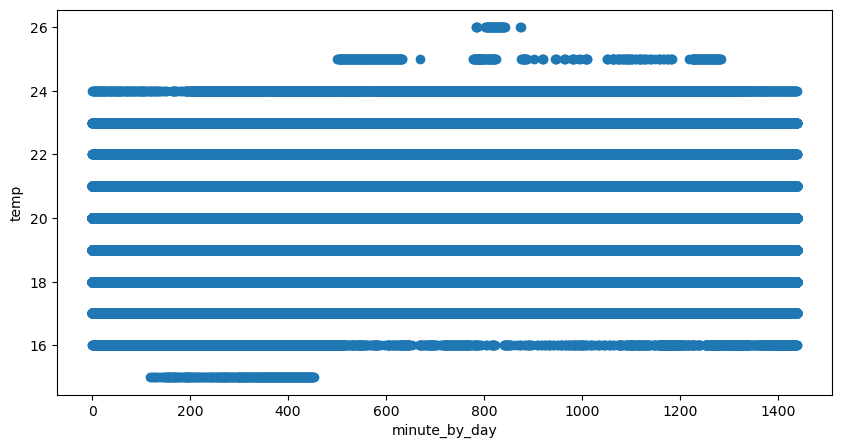

In [12]:
# Data Exploration: Visualization & Analysis
# không groupby
feature1 = 'minute_by_day'
feature2 = 'temp'

# Histogram
plt.figure(figsize=(10, 5))
plt.scatter(data[feature1], data[feature2])
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()

# => không sử dụng được

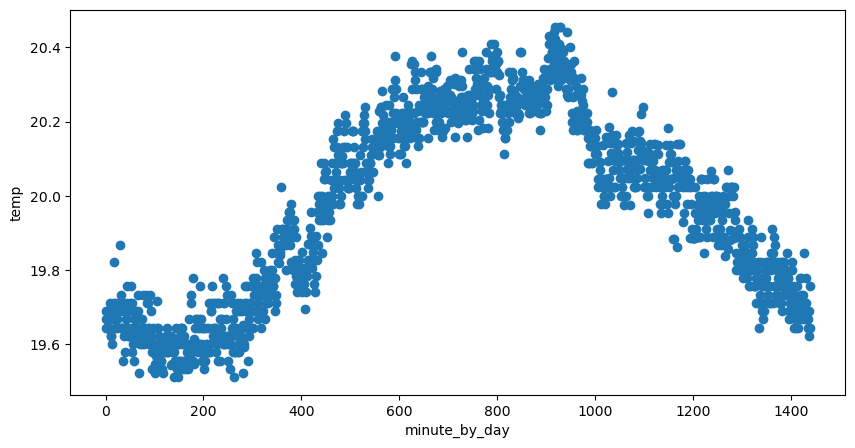

In [13]:
# Data Exploration: Visualization & Analysis
# groupby theo tháng
feature1 = 'minute_by_day'
feature2 = 'temp'
data_split = data[data['month'] == 8]
# Histogram
plt.figure(figsize=(10, 5))
data_group = data_split.groupby(feature1, as_index=False)[feature2].mean()
plt.scatter(data_group[feature1], data_group[feature2])
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()

# => có thể sử dụng được nhưng có 12 mô hình để dự đoán

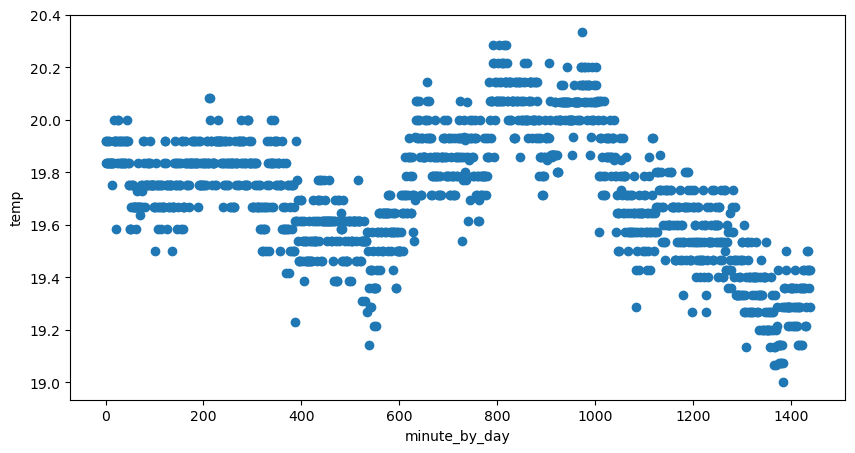

In [14]:
# Data Exploration: Visualization & Analysis
# groupby theo ngày
feature1 = 'minute_by_day'
feature2 = 'temp'
data_split = data[data['day'] == 8]
# Histogram
plt.figure(figsize=(10, 5))
data_group = data_split.groupby(feature1, as_index=False)[feature2].mean()
plt.scatter(data_group[feature1], data_group[feature2])
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()

# => có thể sử dụng được nhưng có 31 mô hình để dự đoán

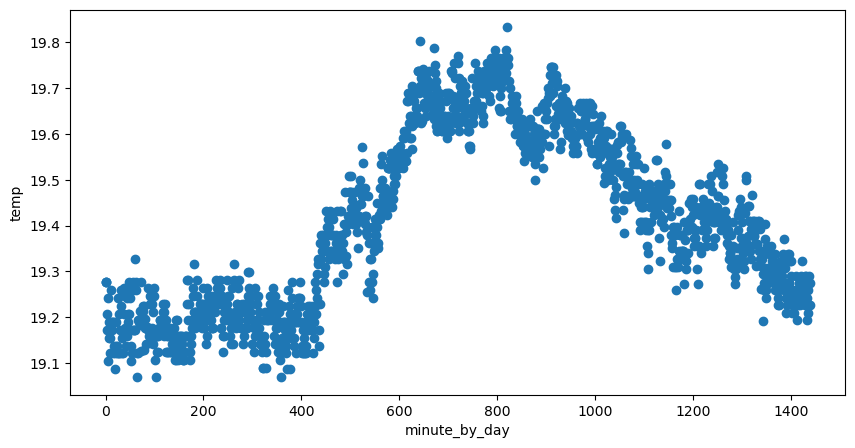

In [15]:
# Data Exploration: Visualization & Analysis
# groupby theo ngày trong tuần
feature1 = 'minute_by_day'
feature2 = 'temp'
data_split = data[data['day_of_week'] == 'Monday']
# Histogram
plt.figure(figsize=(10, 5))
data_group = data_split.groupby(feature1, as_index=False)[feature2].mean()
plt.scatter(data_group[feature1], data_group[feature2])
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()

# => có thể sử dụng được => có 7 mô hình để dự đoán

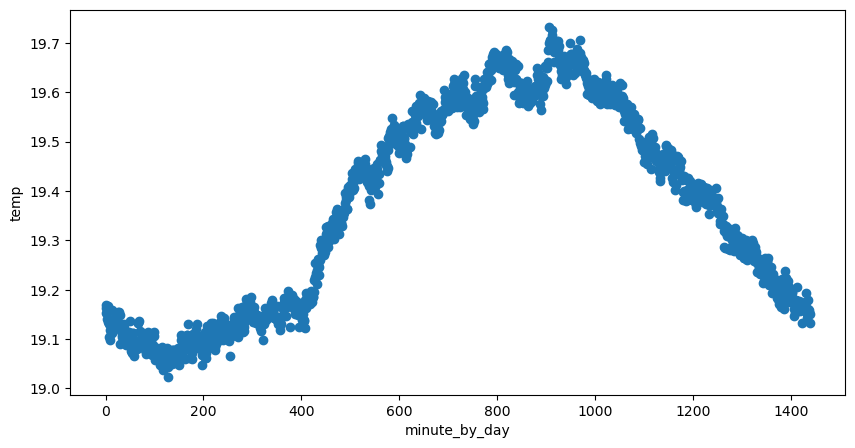

In [16]:
# Data Exploration: Visualization & Analysis
# groupby theo phút trong ngày
feature1 = 'minute_by_day'
feature2 = 'temp'
data_split = data.copy()
# Histogram
plt.figure(figsize=(10, 5))
data_group = data_split.groupby(feature1, as_index=False)[feature2].mean()
plt.scatter(data_group[feature1], data_group[feature2])
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()
# Câu hỏi: có thể sử dụng được hay không?

In [17]:
featureInput = 'minute_by_day'
target = 'temp'
data_group = data.groupby(featureInput, as_index=False)[target].mean()

X = data_group[featureInput].values.reshape(-1, 1)
y = data_group[target].values

print(X)
print(y)

[[   0]
 [   1]
 [   2]
 ...
 [1437]
 [1438]
 [1439]]
[19.16173121 19.15331808 19.16968326 ... 19.15789474 19.13211845
 19.15068493]


In [19]:
degree = 3
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_reg = PolynomialFeatures(degree=degree)
X_poly = poly_reg.fit_transform(X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression()

In [20]:
y_pred = lin_reg.predict(poly_reg.fit_transform(X))
print(y)
print(y_pred)

[19.16173121 19.15331808 19.16968326 ... 19.15789474 19.13211845
 19.15068493]
[19.04883207 19.04887088 19.04891337 ... 19.00496527 19.00214496
 18.99931698]


In [21]:
from sklearn.metrics import r2_score, mean_squared_error
R2 = r2_score(y, y_pred)
RMSE = mean_squared_error(y, y_pred, squared=False)
MSE = mean_squared_error(y, y_pred, squared=True)
print(R2, RMSE, MSE)

0.9217084215218168 0.057564518441416315 0.0033136737833921594
